In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons
import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import warnings
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-adjyo3my
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-adjyo3my
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path) 
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


❌ xóa thành công /kaggle/working/model


In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            img = img / 255.0
            mask = mask / 255.0
    
            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            label = mel_label[index]

            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")
    return images, masks, binary_masks, image_ids, labels

In [ ]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Train_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2017-melanoma/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 635/635 [01:47<00:00,  5.88it/s]



Đã đọc thành công 635 ảnh
Shape của images: (635, 256, 256, 3)
Shape của masks: (635, 256, 256, 1)
Shape của labels: (635,)


In [21]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Test_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 272/272 [00:46<00:00,  5.85it/s]


Đã đọc thành công 272 ảnh
Shape của images: (272, 256, 256, 3)
Shape của masks: (272, 256, 256, 1)
Shape của labels: (272,)


In [22]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def ConvBlock(inputs, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)    
   
    conv2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)
    
    return act2


def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(inputs, skip, filters=64):
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out

def get_U_Net(image_size):
    inputs = layers.Input(image_size)

    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    

    conv_block = ConvBlock(encoder_4, 64*16)
    

    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)
    
    model = models.Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)
model = get_U_Net(input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 256, 256, 64)   │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ re_lu_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 256, 256, 64)   │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_37 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 64)   │              0 │ re_lu_37[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 128, 128, 128)  │            512 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_38 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ re_lu_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 128, 128, 128)  │            512 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_39 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 128)    │              0 │ re_lu_39[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├──────────────────────

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [25]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [26]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
def convert_to_gray_clahe(images):
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

        img_clahe = clahe.apply(gray)  
        grays.append(img_clahe)

    return np.array(grays)

train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

In [ ]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

input_shape = (256, 256, 1)
unet = get_U_Net(input_shape)

unet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'

checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)

start_time = time.time()
history = unet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

print("unet output shape:", unet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7039 - jaccard_coefficient: 0.3226 - loss: 0.5252
Epoch 1: loss improved from inf to 0.43419, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7067 - jaccard_coefficient: 0.3265 - loss: 0.5209 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8446 - jaccard_coefficient: 0.4915 - loss: 0.3424
Epoch 2: loss improved from 0.43419 to 0.33508, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8443 - jaccard_coefficient: 0.4920 - loss: 0.3421 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8606 - jaccard_coefficient: 0.5475 - loss: 0.2933
Epoch 3: loss improved from 0.33508 to 0.28270, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8610 - jaccard_coefficient: 0.5482 - loss: 0.2928 - learning_rate: 0.0010
Epoch 4/100

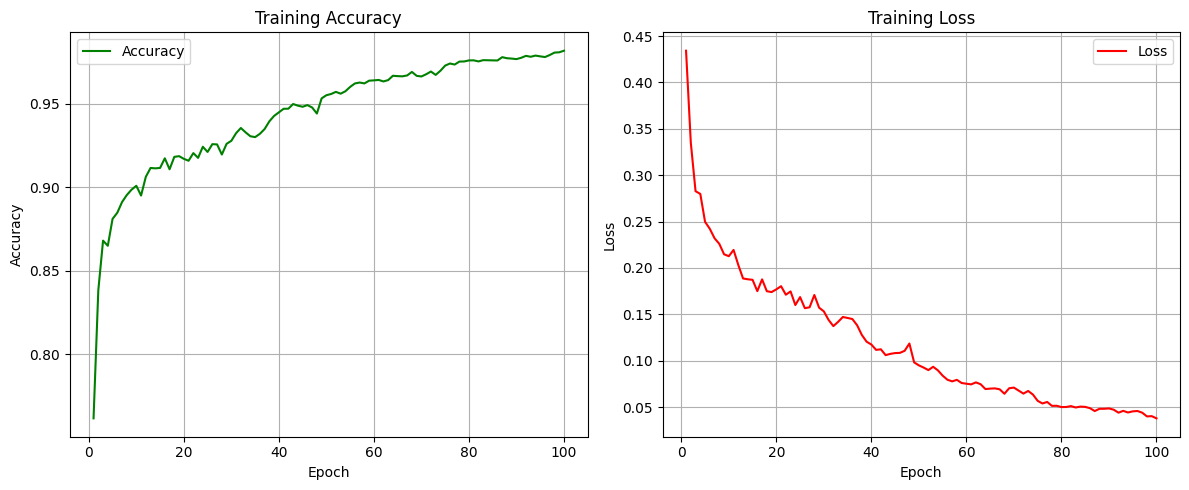

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Gray_2750_acc_loss.png', dpi=300)
plt.show()


In [ ]:
def apply_morphology(mask, kernel_size=3, iterations=1):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  

print("🔍 Đánh giá không hậu xử lý...")
results = unet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

print("\n🔧 Đánh giá sau Morphology...")
predictions1 = unet.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()

    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)


refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 689ms/step - accuracy: 0.9203 - jaccard_coefficient: 0.7087 - loss: 0.1741
Không hậu xử lý - Dice Loss: 0.1994, Accuracy: 91.58%, Jaccard: 67.61%

🔧 Đánh giá sau Morphology...
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 787ms/step


100%|██████████| 272/272 [00:00<00:00, 1593.82it/s]


Sau Morphology - Dice Loss: 0.1844, Accuracy: 91.62%, Jaccard: 68.86%


In [ ]:
unet.save('/kaggle/working/model/2.0-gray_2750_model.h5')
unet.save('/kaggle/working/model/2.0-gray_2750_model.keras')